# Notebook seasonality prediction

In [1]:
import main as tools
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set_style("darkgrid")

# Load everythign into a dictionary
data_dict = tools.load_data_dict()

/var/folders/j7/9q0p2f3967nd4_lknh38gq540000gn/T/ipykernel_10027/3133771617.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(y, ci=None, label='Original data', ax=ax, size=0.5)


ValueError: The following variable cannot be assigned with wide-form data: `size`

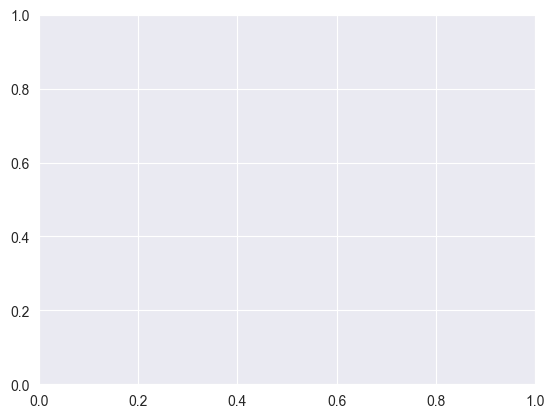

In [7]:
# plotting original data
avg = data_dict['avg']
y = avg['sales']


fig, ax = plt.subplots()
sns.lineplot(y, ci=None, label='Original data', ax=ax)

